In [118]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import jit, lax, random, grad, jacobian, jacfwd, jacrev, vmap
import matplotlib.pyplot as plt

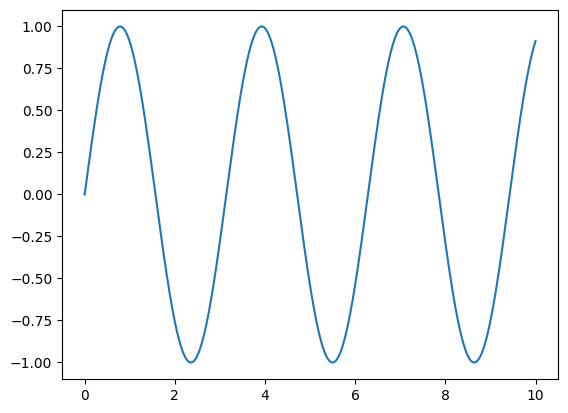

In [2]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2*jnp.sin(x_jnp)*jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [3]:
import numpy as np

In [4]:
x_np = np.linspace(0, 10, 1000)

In [5]:
type(x_np)

numpy.ndarray

In [6]:
type(x_jnp)

jaxlib._jax.ArrayImpl

In [7]:
# Numpy arrays are mutable
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [8]:
# Whereas JAX's arrays are not
x_j = jnp.arange(10)
print(x_j)

[0 1 2 3 4 5 6 7 8 9]


In [9]:
%xmode minimal
# x_j[0] = 10

Exception reporting mode: Minimal


In [10]:
# You can take a copy with a change made, e.g.
y_j = x_j.at[0].set(10)
print(x_j)
print(y_j)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


In [11]:
def log2(x):
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x/ln_2

In [12]:
print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0:f32[]
    d:f32[] = div b c
  in (d,) }


In [13]:
def impure_print_side_effect(x):
    print("Executing function")
    return x

In [14]:
print("First call:", jit(impure_print_side_effect)(4.))

Executing function
First call: 4.0


In [15]:
print("Second call:", jit(impure_print_side_effect)(5.))
# Notice it's calling some cached version that's lost the side-effect of print

Second call: 5.0


In [16]:
print("Third call:", jit(impure_print_side_effect)(jnp.array([5])))
# Notice that the cached version was specialised to a float, and now
# is clearly re-compiling for an int array.

Executing function
Third call: [5]


In [17]:
g = 0

def impure_uses_globals(x):
    return x + g

In [18]:
print("First call:", jit(impure_uses_globals)(4.))

First call: 4.0


In [19]:
g = 10 # Notice that the previous global valus is silently cached
print("Second call:", jit(impure_uses_globals)(4.))

Second call: 4.0


In [20]:
# Notice that it updates when the type is changed from float to int
print("Third call:", jit(impure_uses_globals)(4))

Third call: 14


Also, we shouldn't use iterators and loops within functions as this breaks the functional model.

In [21]:
jnp.zeros(10)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
jnp.linspace(0, 10, 11)

Array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)

In [23]:
jnp.arange(0, 10, 0.5)

Array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5], dtype=float32)

In [24]:
x = jnp.linspace(0, 10, 11)

In [25]:
x.devices()

{CpuDevice(id=0)}

In [26]:
x.sharding

SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=device)

In [27]:
def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

In [28]:
norm(x)

Array([-1.5811388 , -1.264911  , -0.94868326, -0.6324555 , -0.31622776,
        0.        ,  0.31622776,  0.6324555 ,  0.94868326,  1.264911  ,
        1.5811388 ], dtype=float32)

In [29]:
norm_compiled = jit(norm)

In [30]:
norm_compiled(x)

Array([-1.5811388 , -1.264911  , -0.94868326, -0.6324555 , -0.31622776,
        0.        ,  0.31622776,  0.6324555 ,  0.94868326,  1.264911  ,
        1.5811388 ], dtype=float32)

In [31]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000000, 10))

In [32]:
%timeit norm(X).block_until_ready()

42.9 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit norm_compiled(X).block_until_ready()

39.1 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
np.allclose(norm(X), norm_compiled(X), atol=1e-6)

True

In [35]:
def get_negatives(x):
    return x[x < 0]

In [37]:
x = jnp.array(np.random.randn(10))

In [42]:
# jit(get_negatives)(x)
# We can only jit on functions acting on arrays with known and fixed shape.

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[10]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [49]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

In [58]:
x_small = jnp.arange(3.)


In [50]:
print(jax.make_jaxpr(sum_logistic)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = neg a
    c:f32[] = exp b
    d:f32[] = add 1.0:f32[] c
    e:f32[] = div 1.0:f32[] d
    f:f32[] = convert_element_type[new_dtype=float32 weak_type=False] e
    g:f32[] = reduce_sum[axes=() out_sharding=None] f
  in (g,) }


In [60]:
derivative_fn = grad(sum_logistic)

In [61]:
print(jax.make_jaxpr(derivative_fn)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = neg a
    c:f32[] = exp b
    d:f32[] = add 1.0:f32[] c
    e:f32[] = div 1.0:f32[] d
    f:f32[] = integer_pow[y=-2] d
    g:f32[] = convert_element_type[new_dtype=float32 weak_type=False] e
    _:f32[] = reduce_sum[axes=() out_sharding=None] g
    h:f32[] = mul 1.0:f32[] f
    i:f32[] = mul h 1.0:f32[]
    j:f32[] = neg i
    k:f32[] = mul j c
    l:f32[] = neg k
  in (l,) }


In [62]:
derivative_fn(x_small)

Array([0.25      , 0.19661197, 0.10499357], dtype=float32)

In [69]:
def finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


In [71]:
print(finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


In [72]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


In [73]:
from jax

TypeError: the first argument must be callable

In [77]:
print(jacobian(jnp.exp)(x_small))

[[1.        0.        0.       ]
 [0.        2.7182817 0.       ]
 [0.        0.        7.389056 ]]


In [79]:
def hessian(fun):
    return jit(jacfwd(jacrev(fun)))

In [80]:
print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085776 -0.        ]
 [-0.         -0.         -0.07996249]]


In [87]:
def f(x):
    return x**3 + 2*x**2 - 3*x +1

In [88]:
dfdx = grad(f)
d2fdx2 = grad(dfdx)
d3fdx3 = grad(d2fdx2)
d4fdx4 = grad(d3fdx3)

In [89]:
print(f(1.))

1.0


In [90]:
print(dfdx(1.))

4.0


In [91]:
print(d2fdx2(1.))

10.0


In [92]:
print(d3fdx3(1.))

6.0


In [93]:
print(d4fdx4(1.))

0.0


In [94]:
d5fdx5 = grad(d4fdx4)

In [95]:
print(d5fdx5(1.))

0.0


In [104]:
print(jax.make_jaxpr(d5fdx5)(1.))

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=3] a
    c:f32[] = integer_pow[y=2] a
    _:f32[] = mul 3.0:f32[] c
    d:f32[] = integer_pow[y=2] a
    e:f32[] = integer_pow[y=1] a
    _:f32[] = mul 2.0:f32[] e
    _:f32[] = mul 3.0:f32[] d
    f:f32[] = integer_pow[y=2] a
    g:f32[] = integer_pow[y=1] a
    _:f32[] = mul 2.0:f32[] g
    h:f32[] = integer_pow[y=1] a
    i:f32[] = integer_pow[y=0] a
    _:f32[] = mul 1.0:f32[] i
    _:f32[] = mul 2.0:f32[] h
    _:f32[] = mul 3.0:f32[] f
    j:f32[] = integer_pow[y=2] a
    k:f32[] = integer_pow[y=1] a
    _:f32[] = mul 2.0:f32[] k
    l:f32[] = integer_pow[y=1] a
    m:f32[] = integer_pow[y=0] a
    _:f32[] = mul 1.0:f32[] m
    _:f32[] = mul 2.0:f32[] l
    n:f32[] = integer_pow[y=1] a
    o:f32[] = integer_pow[y=0] a
    _:f32[] = mul 1.0:f32[] o
    p:f32[] = integer_pow[y=0] a
    _:f32[] = mul 1.0:f32[] p
    _:f32[] = mul 2.0:f32[] n
    _:f32[] = mul 3.0:f32[] j
    q:f32[] = integer_pow[y=2] a
    r:f32[] = integer_pow[y=

In [111]:
key = random.key(1701)
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

In [113]:
def apply_matrix(x):
    return jnp.dot(mat, x)

In [115]:
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

print("Naively batched")
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
277 μs ± 374 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [117]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, mat.T)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1.e-4, rtol=1.e-4)

print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
25.4 μs ± 145 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [120]:
@jit
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1.e-4, rtol=1.e-4)
print("Auto-vectorized with vmap")
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
25.8 μs ± 127 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [123]:
key = random.key(43)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 43]


In [124]:
print(random.normal(key))

0.07520543


In [125]:
print(random.normal(key))

0.07520543


In [143]:
key = random.key(43)
print(key)
for i in range(3):
    new_key, subkey = random.split(key)
    print(new_key)
    print(subkey)

    del(key)

    val = random.normal(subkey)
    del(subkey)

    print(f"Draw {i}: {val}")
    key = new_key

Array((), dtype=key<fry>) overlaying:
[ 0 43]
Array((), dtype=key<fry>) overlaying:
[3397937756 1294208123]
Array((), dtype=key<fry>) overlaying:
[ 409454506 2300520486]
Draw 0: -1.9133632183074951
Array((), dtype=key<fry>) overlaying:
[ 449051237 3616999620]
Array((), dtype=key<fry>) overlaying:
[3471251761 3587158380]
Draw 1: -1.4749839305877686
Array((), dtype=key<fry>) overlaying:
[3355941758 1286645366]
Array((), dtype=key<fry>) overlaying:
[2991473498 4201888268]
Draw 2: -0.36703771352767944


In [154]:
@jit
def f(x):
    jax.debug.print("x -> {x}", x=x)
    y = jnp.sin(x)
    jax.debug.print("y -> {y}", y=y)
    return y

result = f(2.)

x -> 2.0
y -> 0.9092974066734314
